In [1]:
OUTPUT_ROOT = "./output/csv_oct15_24_simplify_coding_attempts"

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score


def compute_metrics_by_student(
    prediction_df: pd.DataFrame,
) -> dict[str, dict[str, float]]:
    """
    Compute the metrics for each student.
    The metrics include accuracy, ROC-AUC, and RMSE to be consistent with pyBKT.
    """
    # Group by user_id and compute metrics for each group
    metrics_by_student = {}
    for student, student_df in prediction_df.groupby("user_id"):
        # Vectorized accuracy calculation
        predictions = (student_df["correct_predictions"] > 0.5).astype(int)
        accuracy = (student_df["correct"] == predictions).mean()

        # Vectorized AUC calculation
        unique_classes = student_df["correct"].nunique()
        auc = (
            roc_auc_score(student_df["correct"], student_df["correct_predictions"])
            if unique_classes > 1
            else 0.5
        )

        # Vectorized RMSE calculation
        rmse = np.sqrt(
            ((student_df["correct"] - student_df["correct_predictions"]) ** 2).mean()
        )

        metrics_by_student[student] = {
            "accuracy": accuracy,
            "auc": auc,
            "rmse": rmse,
        }

    return metrics_by_student

In [18]:
import glob
import re
from rich.progress import track

all_metrics_by_lo = {}  # learning objective -> metrics by student
all_n_attempts_by_lo = {}  # learning objective -> number of attempts by student

prediction_files = [
    f for f in glob.glob(f"{OUTPUT_ROOT}/*.csv") if "raw_predictions" in f
]

for prediction_path in track(prediction_files, description="Processing files"):
    # Extract the learning objective from the prediction path
    lo = re.search(r"predictions_(\d+\.\d+).csv", prediction_path).group(1)

    prediction_df = pd.read_csv(prediction_path)
    metrics_by_student = compute_metrics_by_student(prediction_df)

    n_attempts_by_students = prediction_df.groupby("user_id").size().to_dict()

    all_metrics_by_lo[lo] = metrics_by_student
    all_n_attempts_by_lo[lo] = n_attempts_by_students

Output()

In [19]:
# Compute average metrics for all learning objectives and store the result in a dataframe
average_metrics_by_lo = {}
for lo, metrics_by_student in all_metrics_by_lo.items():
    average_metrics_by_lo[lo] = {
        "accuracy": np.mean([v["accuracy"] for v in metrics_by_student.values()]),
        "auc": np.mean([v["auc"] for v in metrics_by_student.values()]),
        "rmse": np.mean([v["rmse"] for v in metrics_by_student.values()]),
    }

average_metrics_by_lo = pd.DataFrame(average_metrics_by_lo).T

In [20]:
# save to csv
average_metrics_by_lo.to_csv(f"{OUTPUT_ROOT}/average_metrics_by_lo.csv")

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Enable seaborn notebook style
sns.set_theme("notebook")


def plot_metrics_over_n_attempts(
    lo: str,
    metrics_by_student: dict[str, dict[str, float]],
    n_attempts_by_students: dict[str, int],
    ax: plt.Axes,
    disable_legend: bool = False,
):
    # Get sorted unique attempt counts
    attempt_counts = sorted(n_attempts_by_students.values())

    # Initialize lists to store metrics
    x_attempts = []
    y_accuracy = []
    y_auc = []
    y_rmse = []

    # For each attempt count threshold
    for n_attempts in attempt_counts:
        # Get students with at least this many attempts
        qualified_students = [
            student
            for student, count in n_attempts_by_students.items()
            if count >= n_attempts
        ]

        if len(qualified_students) > 0:
            # Calculate average metrics for qualified students
            avg_accuracy = np.mean(
                [
                    metrics_by_student[student]["accuracy"]
                    for student in qualified_students
                ]
            )
            avg_auc = np.mean(
                [metrics_by_student[student]["auc"] for student in qualified_students]
            )
            avg_rmse = np.mean(
                [metrics_by_student[student]["rmse"] for student in qualified_students]
            )

            x_attempts.append(n_attempts)
            y_accuracy.append(avg_accuracy)
            y_auc.append(avg_auc)
            y_rmse.append(avg_rmse)

    # Plot in the provided ax
    sns.lineplot(x=x_attempts, y=y_accuracy, label="Accuracy", ax=ax)
    sns.lineplot(x=x_attempts, y=y_auc, label="AUC", ax=ax)
    sns.lineplot(x=x_attempts, y=y_rmse, label="RMSE", ax=ax)
    ax.set_xlabel("Minimum Number of Attempts")
    ax.set_ylabel("Average Metric Value")
    ax.set_title(f"Learning Objective {lo}")
    # disable legend
    if disable_legend:
        ax.legend().set_visible(False)
    ax.grid(True)

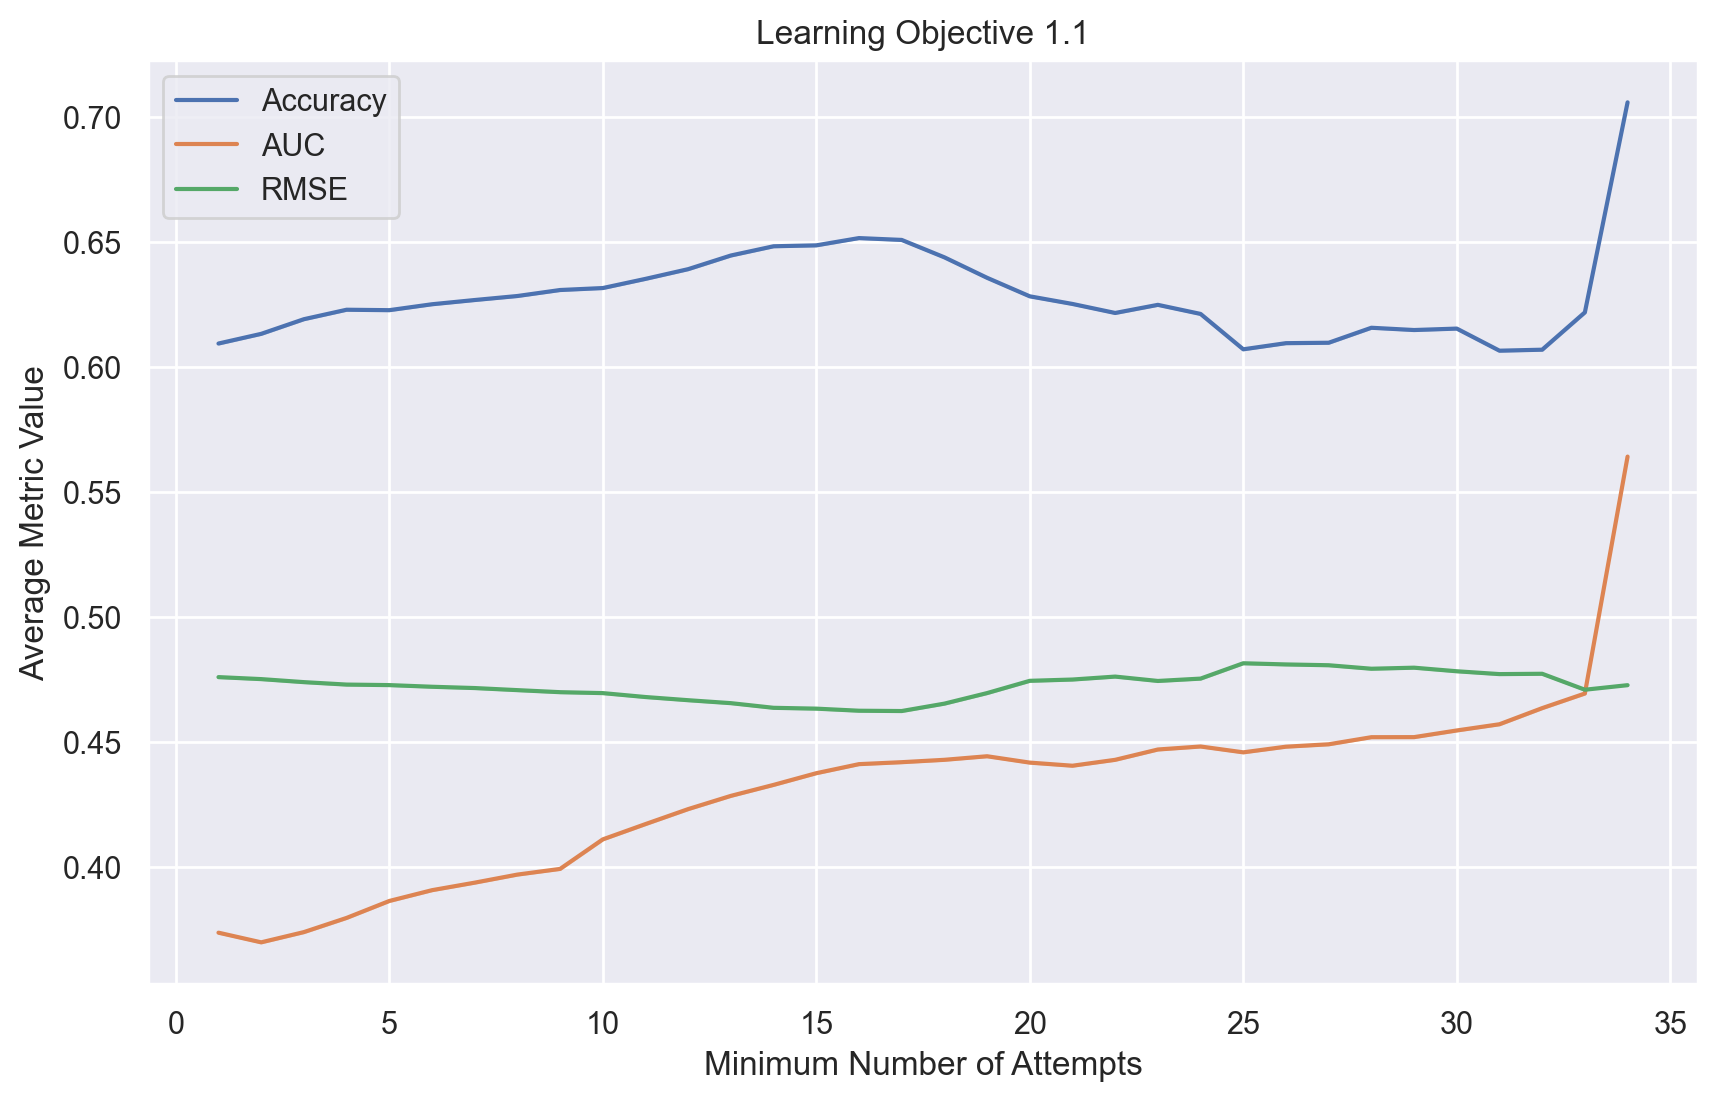

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_metrics_over_n_attempts(
    "1.1", all_metrics_by_lo["1.1"], all_n_attempts_by_lo["1.1"], ax
)
plt.show()

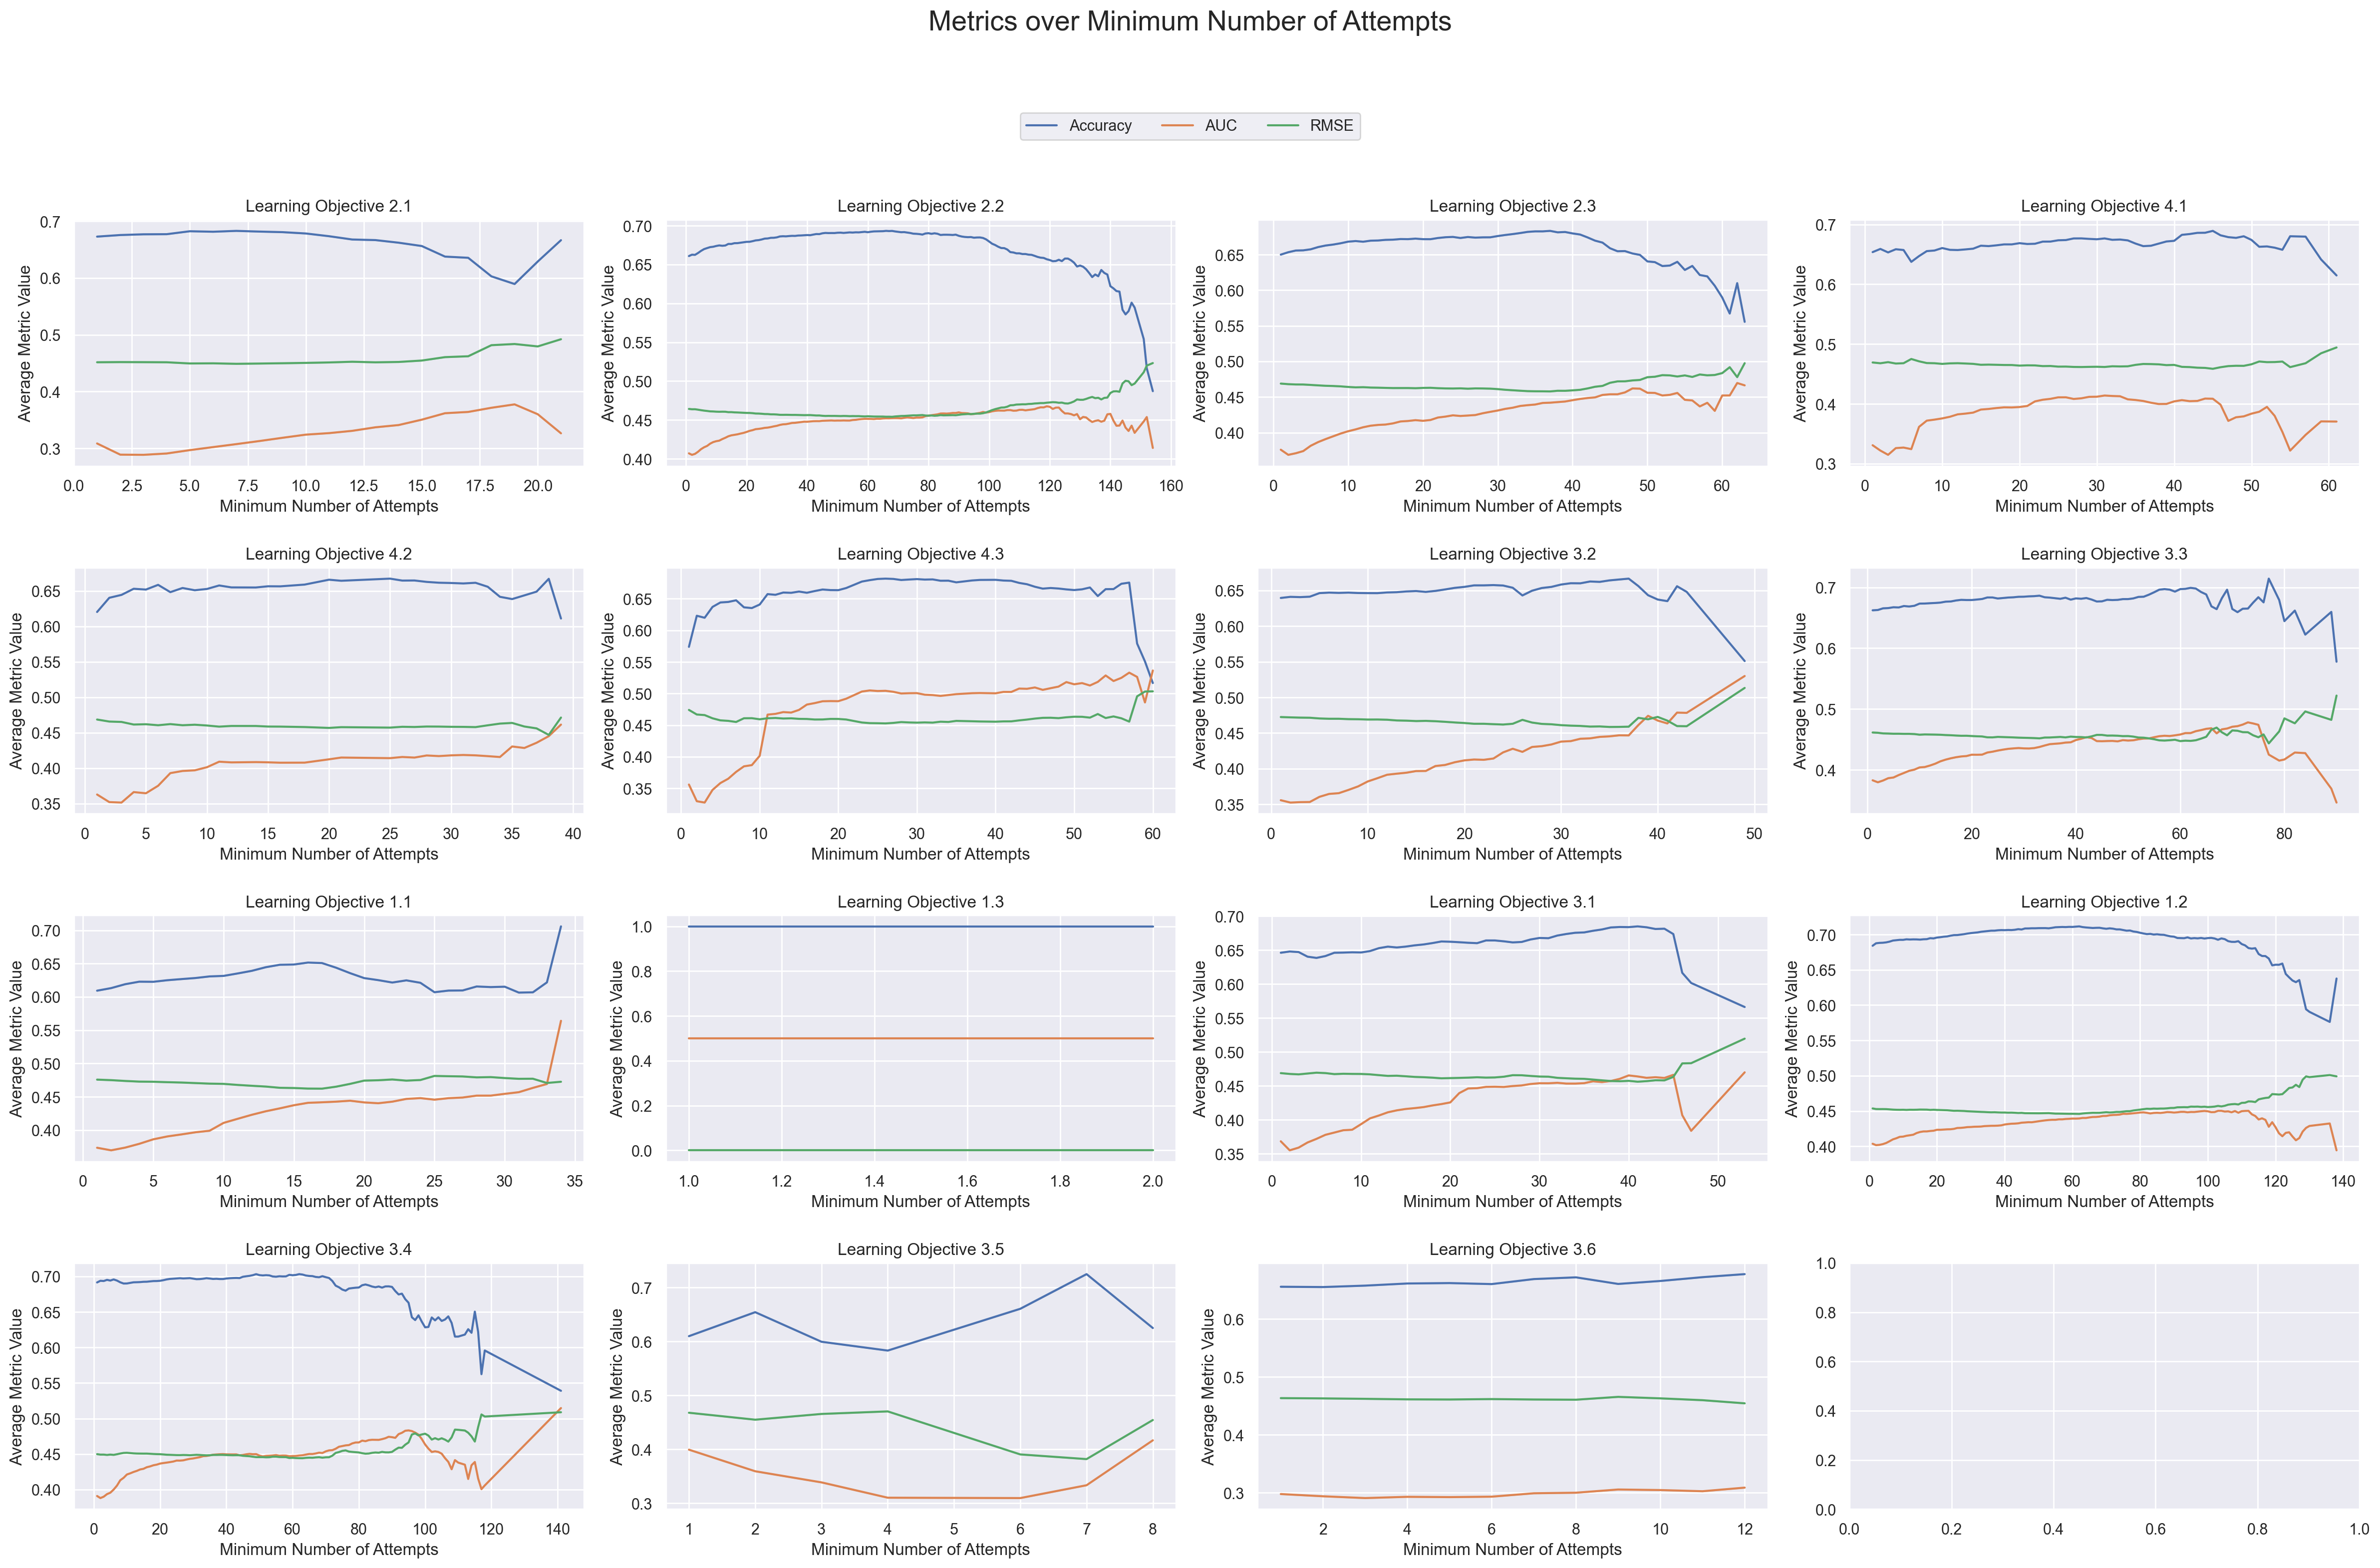

In [51]:
# Draw the plot for all learning objectives, each in a separate subplot in a grid
num_plots = len(all_metrics_by_lo)
num_rows = (num_plots + 3) // 4
num_cols = min(num_plots, 4)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))
for lo, ax in zip(all_metrics_by_lo.keys(), axes.flatten()):
    plot_metrics_over_n_attempts(
        lo, all_metrics_by_lo[lo], all_n_attempts_by_lo[lo], ax, disable_legend=True
    )

# Set the suptitle
fig.suptitle("Metrics over Minimum Number of Attempts", fontsize=20, y=0.98)

# Create a single legend below the suptitle
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.92))

plt.tight_layout(rect=[0, 0, 1, 0.90], h_pad=2.0)
plt.show()